In [1]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [2]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple, Iterable, Any

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map
import seaborn as sns

import config

In [3]:
import torch
from torch.distributions import kl_divergence
from torch.distributions.beta import Beta
from torch.distributions.dirichlet import Dirichlet
from ParameterizedModel.parameterized_model import Paremeterized_Model
from ParameterizedModel.utils.distribution_helpers import mean_std_to_beta_params

from ParameterizedModel.training import Trainer

In [4]:
from gradient_solver import construct_distance_matrix

In [5]:
import timeit

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [7]:
from scipy.spatial.distance import correlation

In [8]:
from gradient_solver import *

In [9]:
'''df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()
df_observable_distances: pd.DataFrame = pd.read_excel(
    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index_col=0
)
features: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())

# Ensure that both datasets contain the same indices
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)
df_explainable = df_explainable.loc[valid_indices]
df_observable_distances = df_observable_distances.loc[valid_indices]'''

'df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()\ndf_observable_distances: pd.DataFrame = pd.read_excel(\n    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",\n    index_col=0\n)\nfeatures: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())\n\n# Ensure that both datasets contain the same indices\nvalid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)\ndf_explainable = df_explainable.loc[valid_indices]\ndf_observable_distances = df_observable_distances.loc[valid_indices]'

In [10]:
##################
# Synthetic Data #
##################
individuals = 100
base_size = 10000

#observation_data = np.random.normal(loc=0, scale=1, size=(base_size, 6))
'''explanation_data = np.random.uniform(0,1, size=(individuals, 11))
df_explainable = pd.DataFrame(explanation_data)
df_explainable.loc[:, 'Individual'] = [f'Individual_{i}' for i in df_explainable.index]
df_explainable.set_index('Individual', inplace=True)'''

df_explainable = pd.DataFrame({
    'Age': np.random.choice([0., 0.5, 1.], individuals),
    'Weight': np.random.uniform(0,1, size=individuals),
    'Is_a_Zebra': np.random.choice([0., 1.], individuals),
    'Loves_to_sleep': np.random.uniform(0,1, size=individuals),
    'Noise_1': np.random.uniform(0,1, size=individuals),
    'Noise_2': np.random.uniform(0,1, size=individuals),
    'Noise_3': np.random.uniform(0,1, size=individuals),
    'Noise_4': np.random.uniform(0,1, size=individuals),
    'Noise_5': np.random.uniform(0,1, size=individuals),
    'Individual': [f'Individual_{n}' for n in range(individuals)]
})
df_explainable.set_index('Individual', inplace=True)

explaining_features = np.array(list(df_explainable.columns))
individual_array = np.random.choice(df_explainable.index.unique(), size=base_size)

df_observable = pd.DataFrame({
    'Individual': individual_array,
})
df_observable.loc[:, 'unexplainable_1'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_2'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_3'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_4'] = np.random.normal(0,1, size=base_size)

df_observable.loc[:, 'if_zebra_then_age'] = (df_explainable.loc[individual_array, 'Is_a_Zebra'].values > 0.5) * df_explainable.loc[individual_array, 'Age'].values + (df_explainable.loc[individual_array, 'Is_a_Zebra'].values <= 0.5) * np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'explained_by_loves_to_sleep'] = df_explainable.loc[individual_array, 'Loves_to_sleep'].values #df_explainable.loc[individual_array, [1,2,3]].mean(axis=1).values #req_1 * df_explainable.loc[individual_array, 2].values + (1-req_1) * df_explainable.loc[individual_array, 3].values
df_observable.loc[:, 'Age_plus_Weight'] = df_explainable.loc[individual_array, 'Age'].values + df_explainable.loc[individual_array, 'Weight'].values

df_observable.set_index('Individual', inplace=True)
observed_features = list(df_observable.columns)

df_observable = df_observable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
df_explainable = df_explainable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [11]:
df_explainable

,Age,Weight,Is_a_Zebra,Loves_to_sleep,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
Individual,,,,,,,,,
Individual_0,1.0,0.917460,0.0,0.163682,0.913696,0.360080,0.527909,0.399460,0.866140
Individual_1,1.0,0.311568,0.0,0.079287,0.525384,0.836613,0.522838,0.804305,0.341387
Individual_2,1.0,0.894556,0.0,0.851180,0.556454,0.008587,0.782924,0.627996,0.597820
Individual_3,0.0,0.059170,1.0,0.644736,0.722115,0.468270,0.783222,0.909401,0.969391
Individual_4,0.0,0.482666,0.0,0.921185,0.573130,0.671872,0.904567,0.858077,0.529314
...,...,...,...,...,...,...,...,...,...
Individual_95,0.0,0.798910,1.0,0.774921,0.420280,0.089496,0.959353,0.489822,0.991733
Individual_96,0.0,0.406351,1.0,0.687618,0.065645,0.416487,0.986966,0.403535,0.783822
Individual_97,1.0,0.345601,1.0,0.000363,0.329413,0.804126,0.831964,0.342994,0.712494


In [12]:
df_observable

,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,if_zebra_then_age,explained_by_loves_to_sleep,Age_plus_Weight
Individual,,,,,,,
Individual_90,0.850673,0.038306,0.641815,0.643843,0.812202,0.911847,0.335508
Individual_4,0.510223,0.815278,0.881421,0.555620,0.680400,0.921185,0.225844
Individual_0,0.578553,0.614229,0.357806,0.415265,0.008529,0.163682,0.958137
Individual_71,0.968138,0.078522,0.567045,0.335072,0.892031,0.459996,0.238296
Individual_61,0.565232,0.119989,0.845901,0.430107,0.522961,0.669044,0.228929
...,...,...,...,...,...,...,...
Individual_10,0.602987,0.770800,0.128555,0.308857,0.000000,0.742632,0.213084
Individual_51,0.736829,0.980073,0.251243,0.541729,0.643006,0.939967,0.291460
Individual_5,0.403869,0.951986,0.491470,0.477184,0.500000,0.413600,0.258810


In [13]:
df_observable.loc['Individual_9']

,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,if_zebra_then_age,explained_by_loves_to_sleep,Age_plus_Weight
Individual,,,,,,,
Individual_9,0.537578,0.674671,0.426368,0.559797,0.715604,1.0,0.315046
Individual_9,0.150078,0.157569,0.865036,0.457120,0.614524,1.0,0.315046
Individual_9,0.044268,0.836054,0.753878,0.429247,0.561497,1.0,0.315046
Individual_9,0.623694,0.246054,0.168555,0.539567,0.396387,1.0,0.315046
Individual_9,0.774193,0.590516,0.371547,0.665451,0.630664,1.0,0.315046
...,...,...,...,...,...,...,...
Individual_9,0.121504,0.531580,0.562008,0.535497,0.956834,1.0,0.315046
Individual_9,0.379184,0.915791,0.949371,0.566596,0.947950,1.0,0.315046
Individual_9,0.463453,0.118228,0.154483,0.448651,0.959382,1.0,0.315046


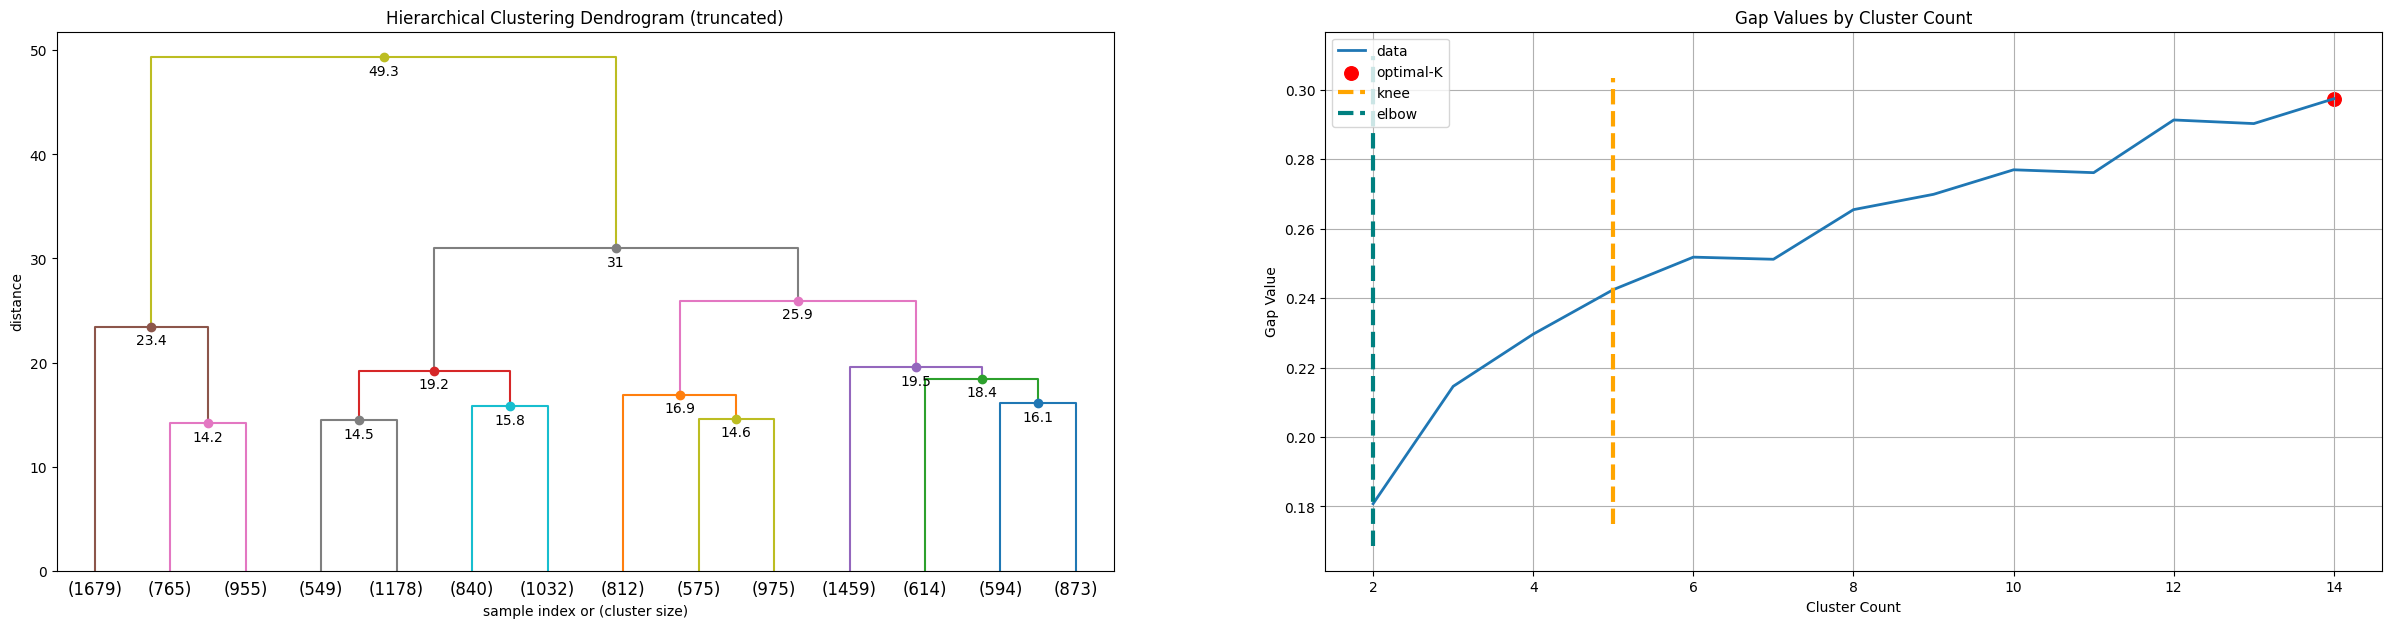

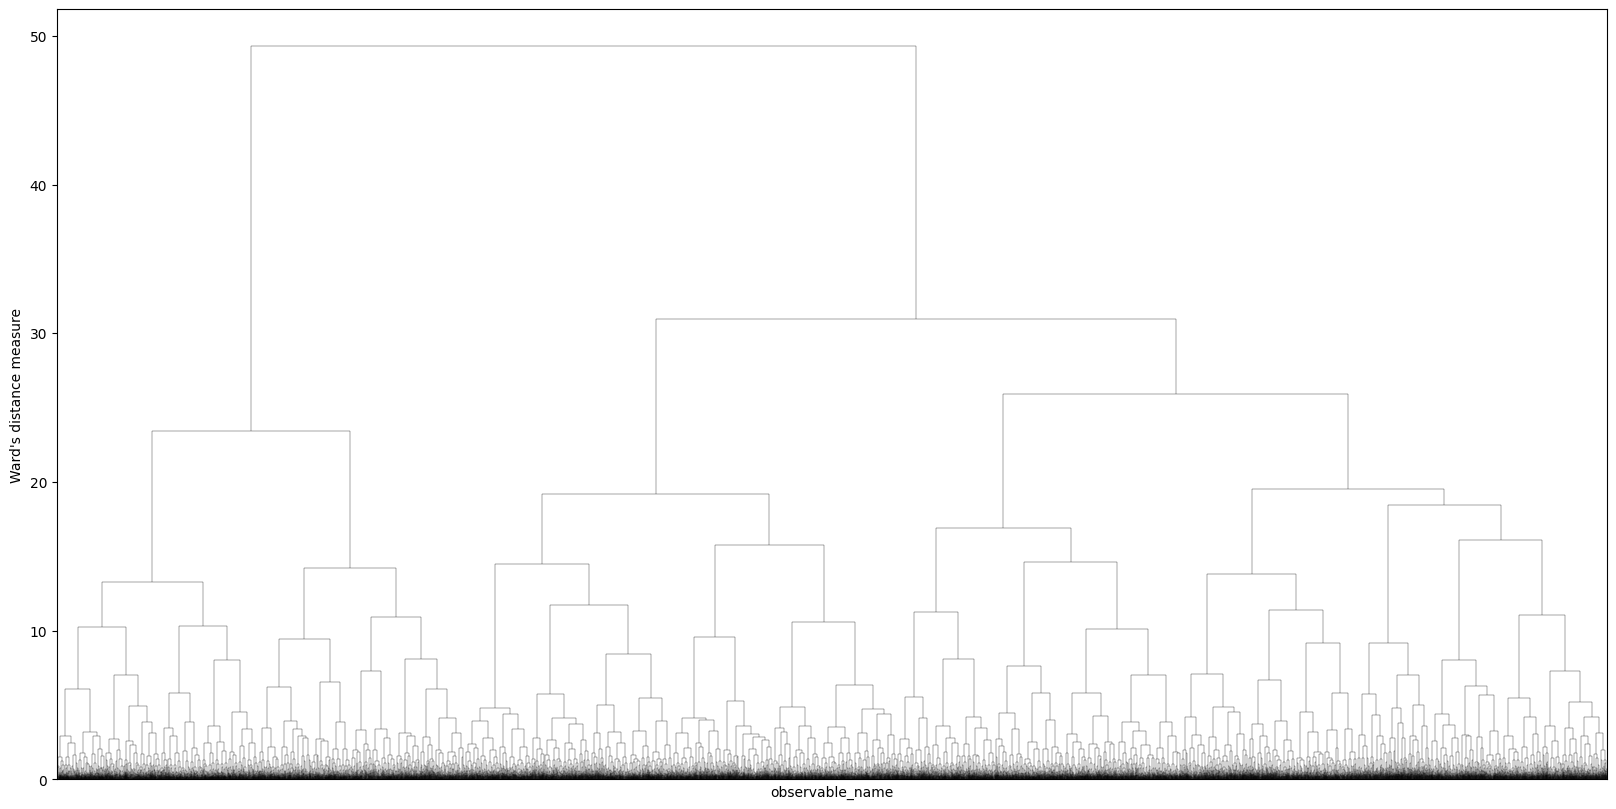

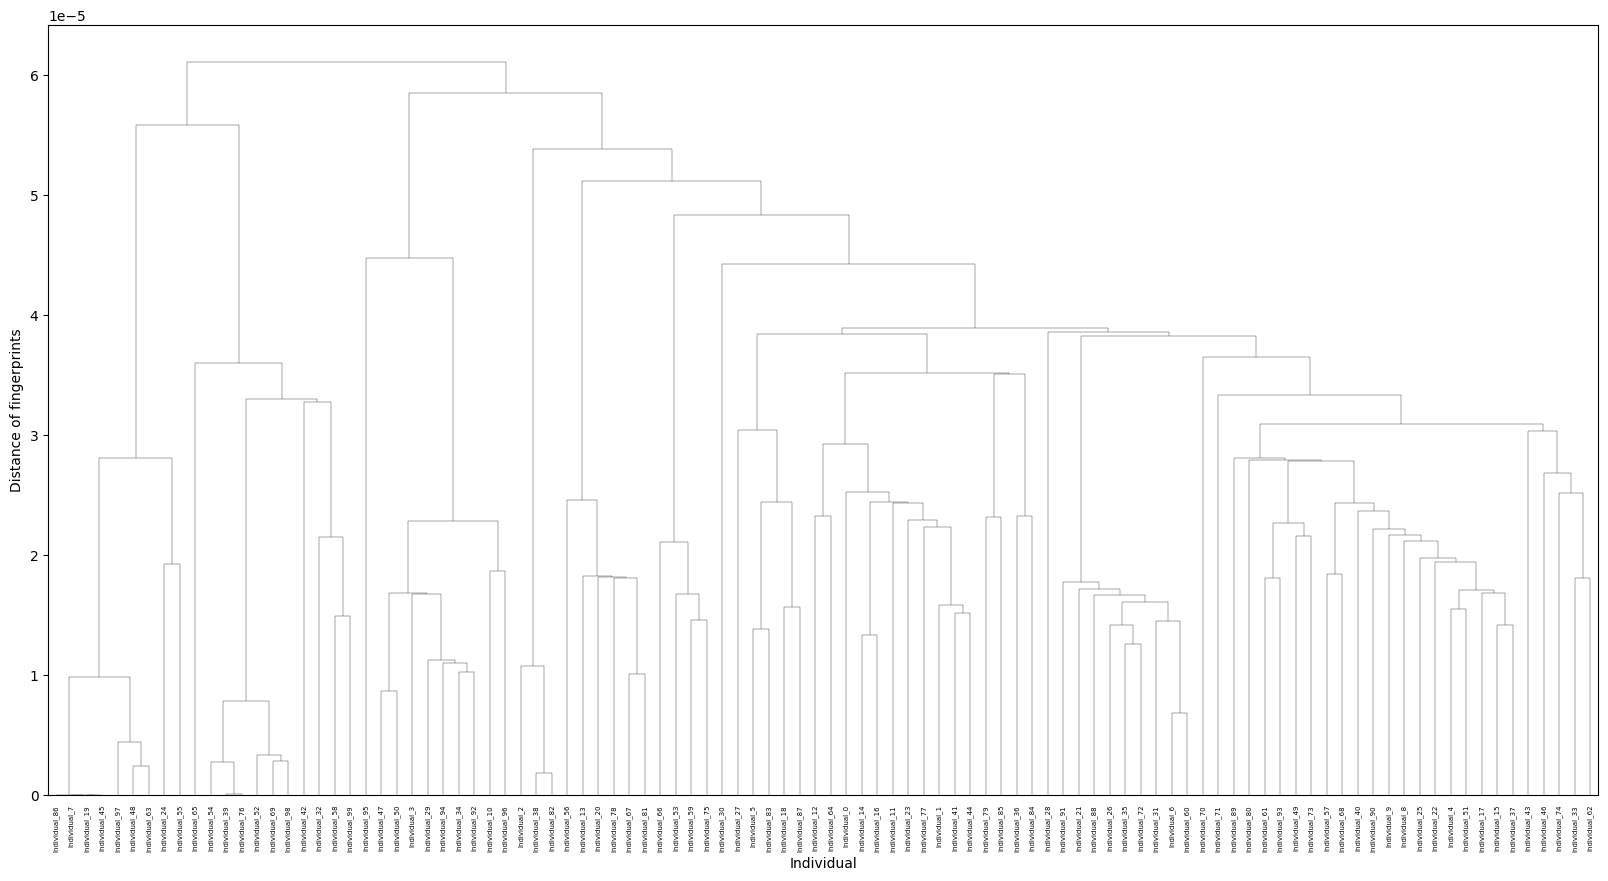

In [14]:
index_name = 'Individual'
my_linkage = 'ward' #'single'

from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

preparation_result = DataPreparator.prepare_data(
    use_config=False,
    df_observable=df_observable.reset_index(),
    df_explainable=df_explainable.reset_index(),
    distortion_mean=0.,
    distortion_std=0.001,
    observed_features=observed_features,
    explaining_features=explaining_features,
    nn_imputation_k=10,
    group_name=index_name,
)
optimal_number_of_clusters = ClusteringApplier.draw_gap_statistic_plot(
    use_config=False, df_observable=preparation_result['observable_df'],
    observed_features=observed_features,
    gap_statistic_cluster_range=15,
    linkage='ward'
)
observable_patterns_result = ClusteringApplier.calculate_observable_patterns(
    use_config=False,
    df_observable_data=preparation_result['observable_df'],
    _n_clusters=optimal_number_of_clusters['n_clusters'],
    observable_name='observable_name',
    observable_feature_names=observed_features,
    plot_title='Name of the fingerprint plot',
    number_observable_patterns='auto',
    distance_measure_fingerprint='jensenshannon',
    group_name=index_name, 
    spiderplot_scaling='minmax',
    linkage=my_linkage
)

In [15]:
observable_patterns_result['spider_plots']

  0%|          | 0/502 [00:00<?, ?it/s]

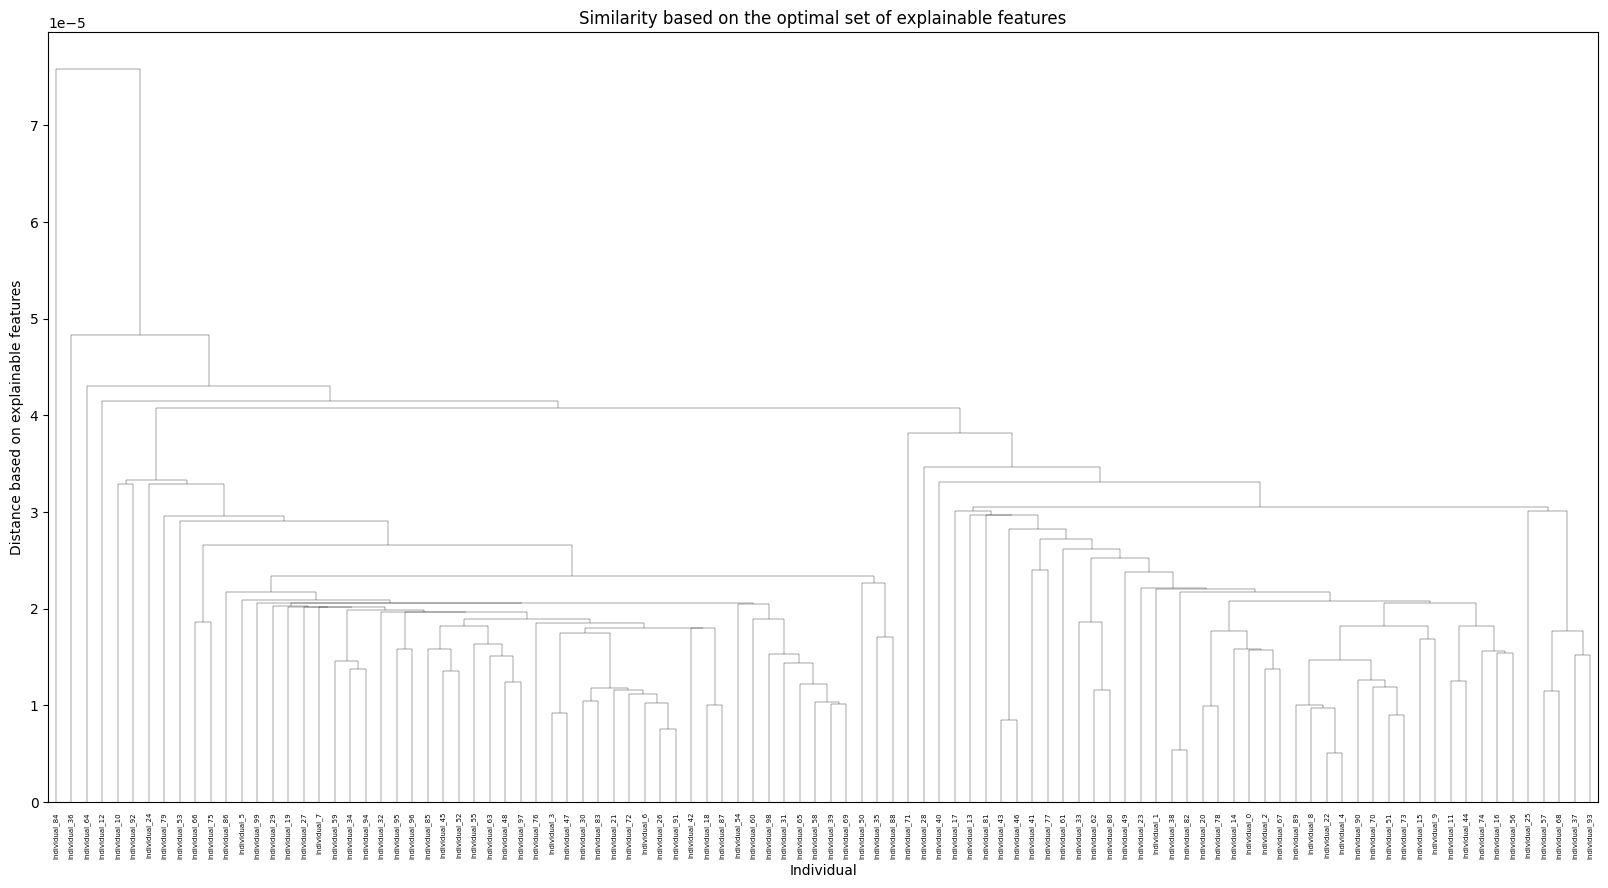

In [16]:
calculate_explainable_distances_result = ClusteringApplier.calculate_explainable_distances(
    use_config=False,
    df_explainable=preparation_result['explainable_df'].copy(),
    df_observable_distances=observable_patterns_result['pw_norm_dist'].copy(),
    explaining_features=explaining_features,
    method='exact',
    distance_measure='correlation',
    sparsity_parameter=0.01,
    max_num_threads=12,
    group_name=index_name
)

In [17]:
calculate_explainable_distances_result['overview_df']

,correlation,Age,Weight,Is_a_Zebra,Loves_to_sleep,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
0,0.363853,1,0,0,1,0,0,0,1,0


In [18]:
def ward_distance(x, y):
    # Compute the centroids of the two clusters
    centroid_x = torch.mean(x, dim=0)
    centroid_y = torch.mean(y, dim=0)

    # Compute the variance within each cluster
    var_x = torch.sum((x - centroid_x) ** 2) / (x.shape[0] - 1)
    var_y = torch.sum((y - centroid_y) ** 2) / (y.shape[0] - 1)

    # Compute the variance between the two clusters
    var_between = torch.sum((centroid_x - centroid_y) ** 2)

    # Compute the Ward distance
    return var_between + var_x + var_y

In [19]:
keystr = 'df_observable_data'

x = torch.tensor(observable_patterns_result[keystr].loc[:, observed_features].to_numpy())
y = torch.tensor(observable_patterns_result['df_cluster_median'].to_numpy())

alternative = ((x.unsqueeze(1) - y.unsqueeze(0)).pow(2).clamp(min=1e-20)).sum(2).sqrt()

vergleich = observable_patterns_result['df_observable_data'].pattern_type == alternative.argmin(dim=1).numpy() #torch.cdist(x, y).argmin(dim=1).numpy()
print(vergleich)
print(vergleich.sum() / observable_patterns_result[keystr].shape[0])

print(alternative.argmin(dim=1).numpy()[:23])
print(observable_patterns_result['df_observable_data'].pattern_type[:23].to_numpy())

0        True
1        True
2        True
3       False
4        True
        ...  
9995    False
9996     True
9997     True
9998     True
9999     True
Name: pattern_type, Length: 10000, dtype: bool
0.7223
[ 8 12  7  9  8  9  4 13  8  9 13  2  8 10  3  5  9  6 13  8  4 11 13]
[ 8 12  7  8  8  0  4 13  8  2 13  0  8 10  3  3  9  6  7  8  4 11 13]


In [20]:
my_df = observable_patterns_result[keystr].copy()
my_df = my_df[my_df["oversampled"] == False]

In [21]:
my_df.loc[:, [index_name] + observed_features]

,Individual,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,if_zebra_then_age,explained_by_loves_to_sleep,Age_plus_Weight
0,Individual_90,0.849980,0.037990,0.642596,0.645526,0.813390,0.911641,0.334562
1,Individual_4,0.510748,0.815361,0.880370,0.556667,0.680695,0.920423,0.225987
2,Individual_0,0.578264,0.612931,0.356424,0.414683,0.007609,0.164091,0.957486
3,Individual_71,0.968228,0.077142,0.566661,0.334070,0.892604,0.458679,0.238236
4,Individual_61,0.564998,0.121111,0.845678,0.430249,0.523643,0.668775,0.229093
...,...,...,...,...,...,...,...,...
9995,Individual_10,0.603815,0.772756,0.128789,0.309160,0.000575,0.743139,0.213859
9996,Individual_51,0.736761,0.979256,0.251908,0.540568,0.643396,0.940177,0.291056
9997,Individual_5,0.404190,0.952369,0.490944,0.477681,0.498151,0.414767,0.256661
9998,Individual_24,0.702300,0.807164,0.376196,0.220506,1.001628,0.169650,0.513349


In [22]:
df_observable_distances = observable_patterns_result['pw_norm_dist']
df_observable_distances.head()

Individual,Individual_0,Individual_1,Individual_10,Individual_11,Individual_12,Individual_13,Individual_14,Individual_15,Individual_16,Individual_17,...,Individual_90,Individual_91,Individual_92,Individual_93,Individual_94,Individual_95,Individual_96,Individual_97,Individual_98,Individual_99
Individual,,,,,,,,,,,,,,,,,,,,,
Individual_0,0.000000,0.000033,0.000121,0.000034,0.000065,0.000081,0.000025,0.000122,0.000032,0.000124,...,0.000125,0.000128,0.000110,0.000111,0.000108,0.000111,0.000119,0.000085,0.000122,0.000108
Individual_1,0.000033,0.000000,0.000115,0.000026,0.000050,0.000093,0.000031,0.000120,0.000029,0.000121,...,0.000123,0.000128,0.000097,0.000106,0.000095,0.000102,0.000112,0.000092,0.000131,0.000119
Individual_10,0.000121,0.000115,0.000000,0.000123,0.000113,0.000125,0.000119,0.000098,0.000116,0.000103,...,0.000093,0.000127,0.000039,0.000103,0.000047,0.000056,0.000019,0.000131,0.000131,0.000131
Individual_11,0.000034,0.000026,0.000123,0.000000,0.000044,0.000096,0.000029,0.000123,0.000034,0.000123,...,0.000126,0.000128,0.000106,0.000109,0.000104,0.000109,0.000121,0.000086,0.000128,0.000115
Individual_12,0.000065,0.000050,0.000113,0.000044,0.000000,0.000105,0.000059,0.000112,0.000056,0.000111,...,0.000114,0.000119,0.000094,0.000093,0.000093,0.000101,0.000113,0.000107,0.000131,0.000119


In [23]:
fingerprint_df = ClusteringApplier._calculate_fingerprints(
    df = my_df,
    group_name = index_name,
    use_config=False,
)

In [24]:
fingerprint_distanzen, normierte_fingerprint_distanzen = ClusteringApplier.calculate_pairwise_fingerprint_distances(
    df = fingerprint_df,
    distance = 'jensenshannon'
)

In [25]:
@torch.jit.script
def torch_relative_entropy(x:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
    return (x * torch.log(x/y))

In [26]:
@torch.jit.script
def new_torch_matrix_jensenshannon(A:torch.Tensor) -> torch.Tensor:

    ########################################################################################
    ### Conversion of the jensenshannon distance from scipy.spatial.distance to pytorch. ###
    ########################################################################################

    """
    Compute the pairwise Jensen-Shannon distance (metric) between
    all entries in a matrix. This is the square root
    of the Jensen-Shannon divergence.

    The Jensen-Shannon distance between two probability
    vectors `p` and `q` is defined as,

    .. math::

       \\sqrt{\\frac{D(p \\parallel m) + D(q \\parallel m)}{2}}

    where :math:`m` is the pointwise mean of :math:`p` and :math:`q`
    and :math:`D` is the Kullback-Leibler divergence.

    This routine will normalize `p` and `q` if they don't sum to 1.0.

    Parameters
    ----------
    A : (N,M) array_like
        matrix of probability vectors
    
    Returns
    -------
    js : double or ndarray
        The Jensen-Shannon distances along the `axis`.

    """
    
    clamped_A = A.clamp(min = 1e-20)
    normalized_A = clamped_A / torch.sum(clamped_A, dim=1).unsqueeze(-1)
    m_A = (normalized_A.unsqueeze(-1) + normalized_A.T).permute(2,0,1) / 2.0
    relative_entropies = torch_relative_entropy(normalized_A, m_A) + 1e-10
    js = (relative_entropies.sum(dim = 2) + relative_entropies.sum(dim = 2).T).clamp(min = 0.)
    return (js / 2.0).sqrt()

In [27]:
class FeatureSelectionModel(Paremeterized_Model):
    def __init__(self, df_explainable:pd.DataFrame, df_observable:pd.DataFrame, df_cluster:pd.DataFrame|torch.Tensor, index_name:str, num_samples:int=1, power:int=4, penalty=0., device='cpu', clip_value=0, dtype=torch.float64):
        super().__init__(device, dtype)

        self.df_explainable = df_explainable.copy()
        self.df_explainable.sort_index(inplace=True)

        self.df_observable = df_observable.copy()
        self.df_observable.sort_values(index_name, inplace=True)
        self.df_observable.reset_index(inplace=True, drop=True)

        self.tensor_explainable = torch.tensor(self.df_explainable.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20, max=1.)
        self.tensor_observable  = torch.tensor(self.df_observable.set_index(index_name).to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20, max=1.)

        if isinstance(df_cluster, pd.DataFrame):
            self.cluster_positions  = torch.tensor(df_cluster.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20)
        else:
            self.cluster_positions = df_cluster.to(self.dtype).to(self.device)

        self.unique_groups = sorted(self.df_observable.loc[:, index_name].unique())
        self.number_of_groups = len(self.unique_groups)
        self.number_of_observations = self.df_observable.shape[0]
        self.mask_tensor = torch.zeros((self.number_of_observations, self.number_of_groups), device=self.device, dtype=self.dtype)

        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            _masking_list = (list(self.df_observable.query(f'{index_name} == "{name}"').index))
            self.mask_tensor[_masking_list, i] = 1.
            if name == 'Individual_0':
                self.masking_1 = _masking_list

        # Some sanity check
        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            lis = (self.mask_tensor.unsqueeze(2) * self.tensor_observable.unsqueeze(1))[:, i, :].nonzero()[:, 0].unique().numpy()
            a = self.df_observable.iloc[lis].loc[:, index_name]
            assert (a == name).all(), f'Failed sanity check for "{name}": {a}'

        self.power = power

        self.feature_names = list(self.df_explainable.columns)
        self.observation_names = list(df_observable.set_index(index_name).columns)

        self.penalty = torch.tensor(penalty, device=self.device, dtype=self.dtype)
        self.num_samples = num_samples
        
        self._add_sigmoid_param('feature_weights', N=len(self.feature_names), value=0.500, noise=0.100)
        self._add_sigmoid_param('observation_weights', N=len(self.observation_names), value=0.500, noise=0.250)

        self.add_param('cluster_positions', self.cluster_positions.logit(), lambda x: x.sigmoid())
        
        self.best_loss = None 
        self.best_feature_weights = None
        self.best_observation_weights = None

        if clip_value > 0:
            for p in self.parameters.parameters():
                print(p)
                p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
 

    def _add_param_from_mean_std(self, param_name='', N=1, mean=0.5, std=0.05, noise=0.1):
        alpha, beta = mean_std_to_beta_params(mean, std)
        
        noise_1 = torch.rand(N)
        noise_2 = torch.rand(N)

        feature_alpha_init = alpha * torch.ones(N) * (1.-noise) + noise_1 * noise
        feature_beta_init  = beta  * torch.ones(N) * (1.-noise) + noise_2 * noise

        self.add_param(f'{param_name}_alpha', torch.log(feature_alpha_init), lambda x: x.exp())
        self.add_param(f'{param_name}_beta',  torch.log(feature_beta_init),  lambda x: x.exp())

    def _add_sigmoid_param(self, param_name='', N=1, value=None, noise=0.1):

        noise_1 = torch.rand(N)
        noisy_value = value * torch.ones(N) * (1.-noise) + noise_1 * noise
        init_value = torch.logit(noisy_value)

        self.add_param(param_name, init_value, lambda x: x.sigmoid()) # [-1., 1.] --> [0, 2]
        #foo = lambda x: x/(1+x.abs())
        #self.add_param(param_name, init_value, lambda x: (foo(x) + 1.)/2.)

    def get_weights(self) -> dict:
        w = self.best_feature_weights
        feature_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.feature_names, w)
        }
        v = self.best_observation_weights
        observation_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.observation_names, v)
        }
        return feature_dict, observation_dict
        
    def save_if_best_loss(self, loss, feature_weights, observation_weights, cluster_positions):
        if self.best_loss is None:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
        elif loss < self.best_loss:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
    
    def plot(self):

        feature_weights = self.constrained('feature_weights').clone().detach().unsqueeze(0).numpy()
        observation_weights = self.constrained('observation_weights').clone().detach().unsqueeze(0).numpy()
        inv_observation_weights = 1.00 + 1e-6 - observation_weights 

        feature_weight_df = pd.DataFrame({self.feature_names[i]:feature_weights[:, i] for i in range(len(self.feature_names))})
        observation_weight_df = pd.DataFrame({self.observation_names[i]:inv_observation_weights[:, i] for i in range(len(self.observation_names))})

        plt.figure(figsize=(10, 5))
        ax1 = sns.barplot(feature_weight_df)
        ax1.axes.xaxis.set_tick_params(rotation=90)
        ax1.set_title('Feature Weights')
        plt.figure(figsize=(10, 5))
        ax2 = sns.barplot(observation_weight_df)
        ax2.axes.xaxis.set_tick_params(rotation=90)
        ax2.set_title('Observation Weights') 

    def sample_fingerprints(self, inv_observation_weights, cluster_positions):
        epsilon = 1e-20
        _dist = ((self.tensor_observable.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(2).clamp(min=epsilon) * inv_observation_weights).sum(2).sqrt()
        norm_dist = (_dist / _dist.sum(dim=1).unsqueeze(-1))
        masked_norm_dist = (self.mask_tensor.unsqueeze(2) * norm_dist.unsqueeze(1))
        accumulated_norm_dist = masked_norm_dist.sum(dim=0)
        fingerprint_distances = accumulated_norm_dist / accumulated_norm_dist.sum(dim=1).unsqueeze(-1)
        pow_fingerprints = ((fingerprint_distances.clamp(min=epsilon))**-1).pow(self.power) 
        sampled_fingerprints = Dirichlet(pow_fingerprints).rsample([self.num_samples]).mean(dim=0)
        return sampled_fingerprints

    def loss(self, data:torch.Tensor|None=None) -> torch.tensor:

        # feature_weights
        feature_weights = self.constrained('feature_weights')

        # observation_weights
        observation_weights = self.constrained('observation_weights')
        inv_observation_weights = 1.00 + 1e-6 - observation_weights 

        # cluster positions
        cluster_positions = self.constrained('cluster_positions').clamp(min = 1e-10, max=1e10)

        # fingerprints
        sampled_fingerprints = self.sample_fingerprints(inv_observation_weights, cluster_positions)

        # Construct the distance matrix for the fingerprints
        fingerprint_distances = new_torch_matrix_jensenshannon(sampled_fingerprints)

        # Construct the distance matrix for the features
        feature_distances = construct_distance_matrix(A=self.tensor_explainable, feature_weights=feature_weights)

        # Calculate the correlation between the distance matrix and the observable distances
        coef = pearson_corrcoef(feature_distances, fingerprint_distances)

        #k_penalty = (feature_weights.sum() * self.penalty)

        # Loss
        loss = -coef #+ k_penalty

        self.save_if_best_loss(loss, feature_weights, observation_weights, cluster_positions)

        return loss


In [45]:
model = next_model

In [59]:
f, e = model.get_weights()
f, e

({'Age': 0.9740008552022131,
  'Weight': 3.085709689557403e-06,
  'Is_a_Zebra': 0.0004493483367509366,
  'Noise_1': 1.195693145906195e-05,
  'Noise_2': 7.860534239871767e-07,
  'Noise_3': 0.047069959545380166,
  'Noise_4': 0.00421150519014505,
  'Noise_5': 0.04381621533527433},
 {'unexplainable_1': 1.6364396232537715e-05,
  'unexplainable_2': 4.587268915390297e-06,
  'unexplainable_3': 7.328757041347167e-06,
  'unexplainable_4': 0.39225915914171217,
  'if_zebra_then_age': 0.9869823759462077,
  'Age_plus_Weight': 0.4797250982136394})

In [87]:
f_l = list(f.keys())
f_w = torch.rand(len(f_l))
f_p = torch.rand(len(f_l))

In [88]:
virtual_feature = {
    'virtual_feature_components': f_l,
    'virtual_feature_weights': f_w,
    'virtual_feature_positions': f_p
}

virtual_feature

{'virtual_feature_components': ['Age',
  'Weight',
  'Is_a_Zebra',
  'Noise_1',
  'Noise_2',
  'Noise_3',
  'Noise_4',
  'Noise_5'],
 'virtual_feature_weights': tensor([0.1991, 0.7992, 0.1898, 0.6935, 0.2644, 0.7504, 0.9604, 0.3925]),
 'virtual_feature_positions': tensor([0.2573, 0.6202, 0.3706, 0.3607, 0.1147, 0.1130, 0.0082, 0.2682])}

In [89]:
i1 = model.tensor_explainable[0]
i1

tensor([9.9864e-01, 9.1590e-01, 1.0000e-20, 9.1550e-01, 3.6080e-01, 5.2798e-01,
        4.0048e-01, 8.6623e-01], dtype=torch.float64)

In [133]:
torch.tensor(0.266)**1e-15

tensor(1.)

<Axes: xlabel='None', ylabel='None'>

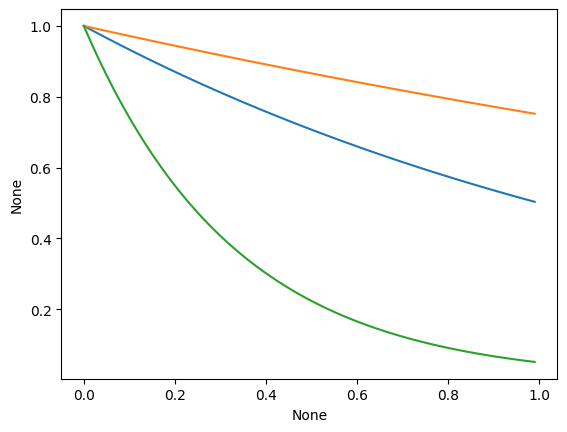

In [131]:
X = torch.arange(100.) / 100.
Y = lambda y: torch.ones(100) * y
sns.lineplot(
    x = X,
    y = Y(0.5)**(X),
)
sns.lineplot(
    x = X,
    y = Y(0.75)**(X),
)
sns.lineplot(
    x = X,
    y = Y(0.05)**(X),
)

In [125]:
virtual_feature['virtual_feature_weights']

tensor([0.1991, 0.7992, 0.1898, 0.6935, 0.2644, 0.7504, 0.9604, 0.3925])

In [126]:
virtual_feature['virtual_feature_positions']

tensor([0.2573, 0.6202, 0.3706, 0.3607, 0.1147, 0.1130, 0.0082, 0.2682])

In [141]:
(i1 - virtual_feature['virtual_feature_positions']).abs().pow(virtual_feature['virtual_feature_weights']).prod()

tensor(0.0232, dtype=torch.float64)

In [307]:
from torch.distributions.uniform import Uniform
U = lambda shape: Uniform(0, 1).sample(shape)

observations = torch.tensor([
    [0.9997, 0.35, 0.45],
    [0.9934, 0.56, 0.65],
    [0.9789, 0.78, 0.54],
    [0.0034, 0.45, 0.74],
    [0.0015, 0.98, 0.47],
    [0.4500, 0.39, 0.32]
])

targets = torch.tensor([
    [0.35],
    [0.56],
    [0.78],
    [0.72],
    [0.64],
    [0.42]
])

antecedens_weights = torch.tensor([0.999, 0.001, 0.001])
consequent_weights = torch.tensor([0.001, 0.999, 0.002])
virtual_feature_postions = torch.tensor([0.001, 0.003, 0.002])
virtual_feature_weights  = torch.tensor([0.999, 0.999, 0.001])

virtual_observation = (observations - virtual_feature_postions).abs().pow(virtual_feature_weights).prod(dim=1)
virtual_observation.numpy().round(2)

array([0.35, 0.55, 0.76, 0.  , 0.  , 0.17], dtype=float32)

In [308]:
antecedens = (observations - virtual_feature_postions).abs().pow(antecedens_weights).prod(dim=1)
antecedens

tensor([9.9684e-01, 9.9140e-01, 9.7707e-01, 2.4118e-03, 5.0342e-04, 4.4842e-01])

In [309]:
consequent = (observations - virtual_feature_postions).abs().pow(consequent_weights).prod(dim=1)
consequent

tensor([0.3468, 0.5568, 0.7762, 0.4444, 0.9682, 0.3862])

In [317]:
(antecedens*consequent) + ((1. - antecedens)*U(consequent.shape))

tensor([0.3474, 0.5583, 0.7802, 0.3861, 0.7491, 0.3137])

In [261]:
U = Uniform(0,1).sample(observations.shape)

In [265]:
(observations - virtual_feature_postions).abs()[:, 0]

tensor([9.9870e-01, 9.9240e-01, 9.7790e-01, 2.4000e-03, 5.0000e-04, 4.4900e-01])

In [267]:
(observations - virtual_feature_postions).abs().pow(virtual_feature_weights)[:, 0]

tensor([9.9870e-01, 9.9241e-01, 9.7792e-01, 2.4145e-03, 5.0381e-04, 4.4936e-01])

In [262]:
(observations - virtual_feature_postions).abs()

tensor([[9.9870e-01, 3.4700e-01, 4.4800e-01],
        [9.9240e-01, 5.5700e-01, 6.4800e-01],
        [9.7790e-01, 7.7700e-01, 5.3800e-01],
        [2.4000e-03, 4.4700e-01, 7.3800e-01],
        [5.0000e-04, 9.7700e-01, 4.6800e-01],
        [4.4900e-01, 3.8700e-01, 3.1800e-01]])

In [ ]:
# Subjunktion
# A -> B
# A*B + (1-A)*U

In [ ]:
[0.35, 0.55, 0.76, U, U, (0.17)+(0.83*U)]

In [256]:
(observations - virtual_feature_postions).abs().pow(virtual_feature_weights)

tensor([[9.9870e-01, 3.4737e-01, 9.9920e-01],
        [9.9241e-01, 5.5733e-01, 9.9957e-01],
        [9.7792e-01, 7.7720e-01, 9.9938e-01],
        [2.4145e-03, 4.4736e-01, 9.9970e-01],
        [5.0381e-04, 9.7702e-01, 9.9924e-01],
        [1.2053e-02, 3.8737e-01, 9.9885e-01]])

In [ ]:
'''
Haben:
Konjunktion, Negation

De Morgansche Gesetze:
~(a and b) = ~a or ~b
a or b = ~((~a) and (~b))




'''

In [128]:
model.best_observation_weights

tensor([1.6364e-05, 4.5873e-06, 7.3288e-06, 3.9226e-01, 9.8698e-01, 4.7973e-01],
       dtype=torch.float64)

In [129]:
my_feature_weights = model.best_feature_weights

In [130]:
my_feature_weights
my_feature_weights = torch.tensor([0.999, 1e-7, 0.999, 1e-7, 1e-7, 1e-7, 1e-7, 1e-7])

In [50]:
model.best_observation_weights
my_observation_weights = torch.tensor([1e-7, 1e-7, 1e-7, 1e-7, 0.999, 1e-7])#model.best_observation_weights

In [51]:
my_observation_weights = model.best_observation_weights

In [52]:
sampled_fingerprints = model.sample_fingerprints(model.best_observation_weights, model.best_cluster_positions)
fingerprint_distances = new_torch_matrix_jensenshannon(sampled_fingerprints)
fingerprint_distances.shape

torch.Size([100, 100])

In [53]:
fdm1 = construct_distance_matrix(A=model.tensor_explainable, feature_weights=my_feature_weights)

In [54]:
fdm2 = construct_distance_matrix(A=model.tensor_explainable * my_feature_weights, feature_weights=torch.tensor(1.))

In [55]:
pearson_corrcoef(fdm1, fingerprint_distances)

tensor(0.3438, dtype=torch.float64)

In [56]:
pearson_corrcoef(fdm2, fingerprint_distances)

tensor(0.2741, dtype=torch.float64)

In [57]:
model.df_explainable.iloc[86]

Age           0.500882
Weight        0.539986
Is_a_Zebra    1.000167
Noise_1       0.332540
Noise_2       0.835651
Noise_3       0.103162
Noise_4       0.303421
Noise_5       0.398485
Name: Individual_87, dtype: float64

In [1128]:
#mi = model.df_explainable.Loves_to_sleep.min()
#p = model.df_explainable.query(f'Loves_to_sleep == {mi}')
mi = model.df_explainable.Age.min()
p = model.df_explainable.query(f'Age == {mi}')
p

,Age,Weight,Is_a_Zebra,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
Individual,,,,,,,,
Individual_25,-0.001811,0.802471,0.999542,0.00027,0.530347,0.311026,0.31275,0.941873


In [1129]:
#ma = model.df_explainable.Loves_to_sleep.max()
#q = model.df_explainable.query(f'Loves_to_sleep == {ma}')
ma = model.df_explainable.Age.max()
q = model.df_explainable.query(f'Age == {ma}')
q

,Age,Weight,Is_a_Zebra,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
Individual,,,,,,,,
Individual_63,1.002025,0.097236,0.999748,0.934427,0.810331,0.688965,0.633527,0.261519


In [1130]:
lowest_value_index = model.df_explainable.reset_index().query(f'Individual == "{p.iloc[0].name}"').index[0]
highest_value_index = model.df_explainable.reset_index().query(f'Individual == "{q.iloc[0].name}"').index[0]

In [1131]:
rndm = np.random.randint(0, 99)

In [1132]:
# low->low, low->high
(fdm1[lowest_value_index][lowest_value_index].numpy() * 100000).round(0), (fdm1[lowest_value_index][highest_value_index].numpy() * 100000).round(0)

(np.float64(0.0), np.float64(6.0))

In [1133]:
# high->low, high->high
(fdm1[highest_value_index][lowest_value_index].numpy() * 100000).round(0), (fdm1[highest_value_index][highest_value_index].numpy() * 100000).round(0)

(np.float64(6.0), np.float64(0.0))

In [1134]:
# rndm->low, rndm->high
(fdm1[rndm][lowest_value_index].numpy() * 100000).round(0), (fdm1[rndm][highest_value_index].numpy() * 100000).round(0)

(np.float64(21.0), np.float64(6.0))

In [1135]:
(fdm2[rndm][lowest_value_index].numpy() * 100000).round(0), (fdm2[rndm][highest_value_index].numpy() * 100000).round(0)

(np.float64(22.0), np.float64(6.0))

In [1136]:
(fingerprint_distances[rndm][lowest_value_index].numpy() * 1000).round(0), (fingerprint_distances[rndm][highest_value_index].numpy() * 1000).round(0)

(np.float64(742.0), np.float64(37.0))

In [1145]:
rndm = np.random.randint(0, 99)
(fdm1[rndm].numpy() * 100000).round(0)

array([ 0., 21.,  6., 13., 11.,  6., 11., 11., 11., 11., 21.,  0.,  6.,
        6., 21., 11., 21.,  0., 21., 21., 21., 10., 21.,  0., 21.,  0.,
       11.,  0.,  0.,  0., 21., 21., 11., 21., 11.,  0., 21., 21., 11.,
       11., 11.,  0., 11.,  0.,  0.,  0., 21.,  0., 11.,  0., 21., 21.,
       11., 21.,  0.,  6., 11., 21.,  0.,  0.,  6.,  0.,  0.,  0., 21.,
        6.,  0., 18., 21., 21., 11., 21.,  6., 21., 21.,  0.,  0.,  0.,
        5.,  0., 21., 20., 21., 21., 10.,  0., 11.,  0.,  5.,  6.,  0.,
        0.,  0.,  0.,  0.,  2.,  0.,  0., 21., 21.])

In [1146]:
(fingerprint_distances[rndm].numpy() * 1000).round(0)

array([ 93., 730., 148., 611., 207., 116., 152., 205., 308., 192., 699.,
       111., 116., 137., 114., 209., 758.,  85., 695., 714., 355., 301.,
       451.,  70., 681., 101., 141.,  43.,  48.,  85., 754., 730., 112.,
       328., 171.,   0., 372., 739., 204., 207.,  91.,  98., 209.,  10.,
       253.,  96., 686.,  24., 313.,  47., 699., 196., 137., 636., 127.,
       131., 208., 742.,  72.,  19., 125., 255., 136.,  47., 756., 129.,
        42.,  50., 731., 595., 137., 608., 115., 332., 207.,  27., 136.,
       285., 298.,  77., 432., 595., 762., 757., 592.,  87.,  87.,  27.,
       352., 140.,  51., 109.,  92.,  54.,  33., 621., 216.,   8., 664.,
       715.])

In [1147]:
np.corrcoef(fdm1[rndm], fingerprint_distances[rndm].numpy())

array([[1.        , 0.77614862],
       [0.77614862, 1.        ]])

In [1140]:
np.corrcoef(fdm1.flatten(), fingerprint_distances.numpy().flatten())

array([[1.        , 0.40309883],
       [0.40309883, 1.        ]])

In [1141]:
np.corrcoef(fdm2[rndm], fingerprint_distances[rndm].numpy())

array([[ 1.        , -0.50606463],
       [-0.50606463,  1.        ]])

In [659]:
Tier_0 = np.array([0.5, 0.0]) # Alter: Mittel, KEIN Zebra
Tier_1 = np.array([0.0, 1.0]) # Alter: Jung,   Zebra
Tier_2 = np.array([1.0, 1.0]) # Alter: Alt,    Zebra

[
    correlation(Tier_0, Tier_1, centered=False),
    correlation(Tier_0, Tier_2, centered=False),
    correlation(Tier_1, Tier_2, centered=False),
]

[np.float64(1.0),
 np.float64(0.29289321881345254),
 np.float64(0.29289321881345254)]

In [660]:
torch_matrix_correlation(
    torch.tensor([
        Tier_0,
        Tier_1,
        Tier_2
    ]),
    w = torch.tensor([1., 1e-10])
)

tensor([[0.0000e+00, 1.0000e+00, 5.0000e-11],
        [1.0000e+00, 0.0000e+00, 9.9999e-01],
        [5.0000e-11, 9.9999e-01, 0.0000e+00]], dtype=torch.float64)

In [132]:
torch_matrix_correlation(
    torch.tensor([
        Tier_0,
        Tier_1,
        Tier_2
    ]),
    w = torch.tensor([1., 1])
)

tensor([[0.0000, 1.0000, 0.2929],
        [1.0000, 0.0000, 0.2929],
        [0.2929, 0.2929, 0.0000]], dtype=torch.float64)

In [129]:
torch.tensor([
        Tier_0,
        Tier_1,
        Tier_2
    ])

tensor([[0.5000, 0.0000],
        [0.0000, 1.0000],
        [1.0000, 1.0000]], dtype=torch.float64)

In [44]:
w = torch.tensor([1., 1e-10])
w = w / w.sum()
torch.tensor([
    Tier_0,
    Tier_1,
    Tier_2
]) * w

NameError: name 'Tier_0' is not defined

In [148]:
Tier_0, Tier_2

(array([0.5, 0. ]), array([1., 1.]))

In [149]:
correlation([0.5, 0., 0.], [1., 1., 0.], centered=False, w=[1., 1., 1.])

np.float64(0.29289321881345254)

In [153]:
correlation([0.5, 0., 0.], [1., 1., 0.], centered=False, w=[1., 1e-10, 1.])

np.float64(5.000000413701855e-11)

In [137]:
correlation(Tier_0, Tier_2, centered=False, w=[1., 1.])

np.float64(0.29289321881345254)

In [138]:
correlation(Tier_0, Tier_2, centered=False, w=[1., 1e-10])

np.float64(5.000000413701855e-11)

In [157]:
correlation(
    np.array([0.028, 0.999]),
    np.array([1.000, 1.000]),
    centered=False,
    w=[1,0.00001]
)

np.float64(0.005955107656836156)

In [88]:
correlation(df_explainable.loc['Individual_1', ['Age', 'Is_a_Zebra']].to_numpy().clip(min=0), df_explainable.loc['Individual_2', ['Age', 'Is_a_Zebra']].to_numpy().clip(min=0), centered=False)

np.float64(0.292740206450986)

In [ ]:
correlation(df_explainable.loc['Individual_0', ['Age', 'Is_a_Zebra']].to_numpy().clip(min=0), df_explainable.loc['Individual_1', ['Age', 'Is_a_Zebra']].to_numpy().clip(min=0), centered=False)

np.float64(0.9975204890409671)

In [ ]:
correlation([0.5, 0.], [0., 1.], centered=False) # 

np.float64(1.0)

In [29]:
from gradient_solver import _construct_distance_matrix

In [30]:
df_explainable = preparation_result['explainable_df'].copy().set_index(index_name)
df_observable = observable_patterns_result['df_observable_data'].copy().set_index(index_name).loc[:, observed_features].reset_index()

In [31]:
model = FeatureSelectionModel(
    df_explainable,
    df_observable,
    observable_patterns_result['df_cluster_median'],
    power = 2,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.2402482670188497
1/10 --- Mean Loss : -0.9450397488663858
2/10 --- Mean Loss : -0.9866583421496515
3/10 --- Mean Loss : -0.9948335531375683
4/10 --- Mean Loss : -0.9971081727914691
5/10 --- Mean Loss : -0.9977949515959404
6/10 --- Mean Loss : -0.9983226614825543
7/10 --- Mean Loss : -0.9986375227883308
8/10 --- Mean Loss : -0.999008538614623
9/10 --- Mean Loss : -0.9992354289653294
10/10 --- Mean Loss : -0.9992565640044511


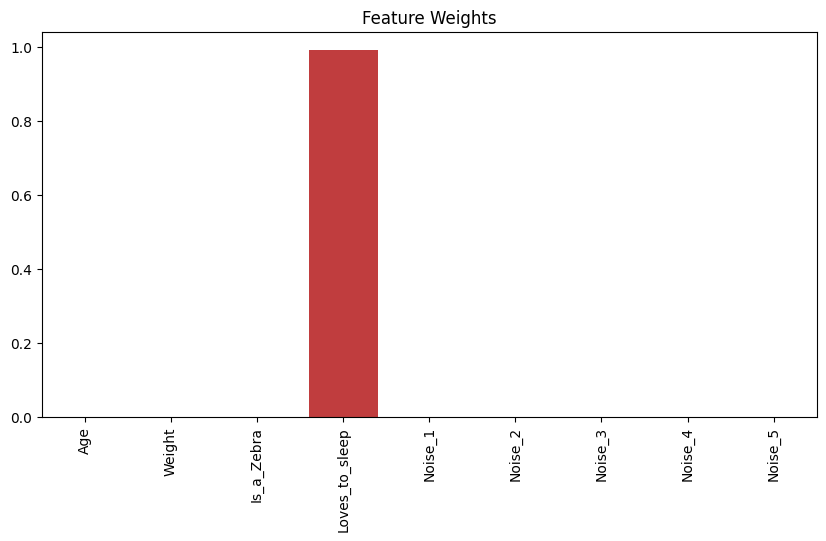

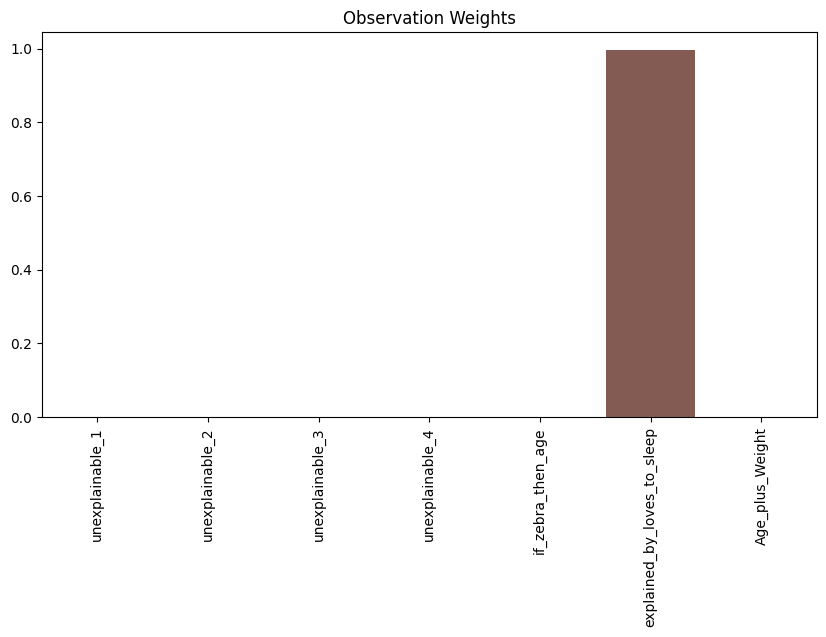

In [32]:
model.plot()

In [33]:
feature_dict, observation_dict = model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

In [34]:
remaining_features, remaining_observations

(['Age',
  'Weight',
  'Is_a_Zebra',
  'Noise_1',
  'Noise_2',
  'Noise_3',
  'Noise_4',
  'Noise_5'],
 ['Individual',
  'unexplainable_1',
  'unexplainable_2',
  'unexplainable_3',
  'unexplainable_4',
  'if_zebra_then_age',
  'Age_plus_Weight'])

In [35]:
next_model = FeatureSelectionModel(
    df_explainable.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

# After this many steps, the learning rate is halved
HALFLIFE = 50

optimizer = torch.optim.RMSprop(
    params = [
        {'params': next_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': next_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': next_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = next_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {next_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.18437438554024
1/10 --- Mean Loss : -0.7335775033032934
2/10 --- Mean Loss : -0.7658767019687115
3/10 --- Mean Loss : -0.7663229709133603
4/10 --- Mean Loss : -0.766493230573964
5/10 --- Mean Loss : -0.7665870406386681
6/10 --- Mean Loss : -0.766656425287316
7/10 --- Mean Loss : -0.7666939794678356
8/10 --- Mean Loss : -0.7667223421065557
9/10 --- Mean Loss : -0.7667611183246354
10/10 --- Mean Loss : -0.7668012410740601


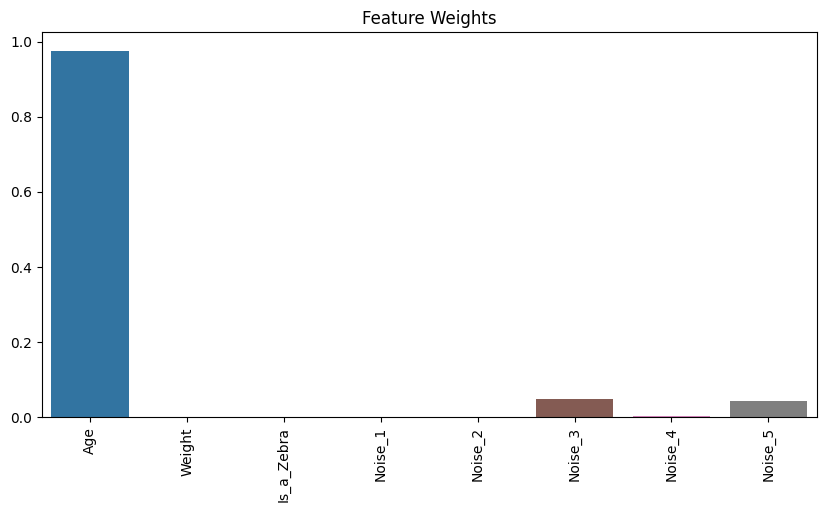

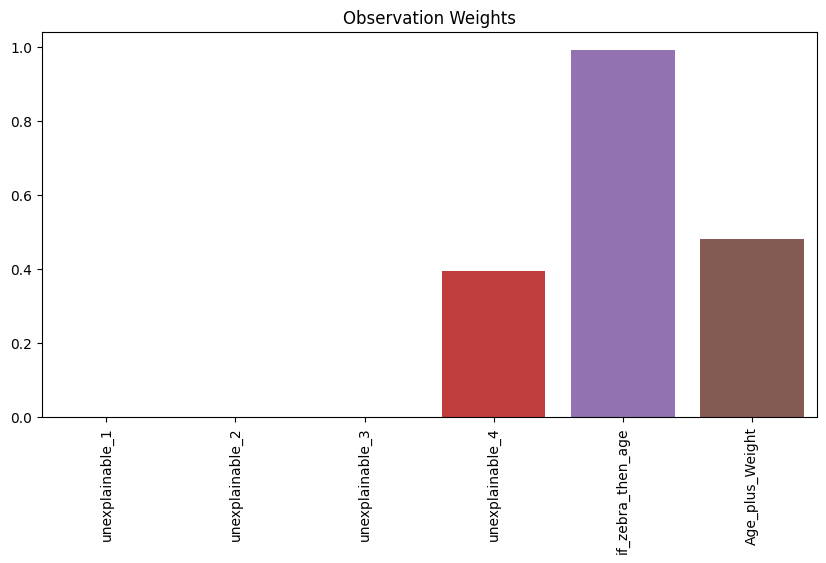

In [36]:
next_model.plot()

In [37]:
feature_dict, observation_dict = next_model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

remaining_features, remaining_observations

(['Weight',
  'Is_a_Zebra',
  'Noise_1',
  'Noise_2',
  'Noise_3',
  'Noise_4',
  'Noise_5'],
 ['Individual',
  'unexplainable_1',
  'unexplainable_2',
  'unexplainable_3',
  'unexplainable_4',
  'Age_plus_Weight'])

In [38]:
next2_model = FeatureSelectionModel(
    df_explainable.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

my_model = next2_model

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': my_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = my_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {my_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.09448573854780432
1/10 --- Mean Loss : -0.27803924625795035
2/10 --- Mean Loss : -0.32173400554503023
3/10 --- Mean Loss : -0.3420414633358865
4/10 --- Mean Loss : -0.3684916091795158
5/10 --- Mean Loss : -0.40670472240492234
6/10 --- Mean Loss : -0.4430751086539664
7/10 --- Mean Loss : -0.45669980054745535
8/10 --- Mean Loss : -0.46200064418725617
9/10 --- Mean Loss : -0.46288694787962575
10/10 --- Mean Loss : -0.46372955243797315


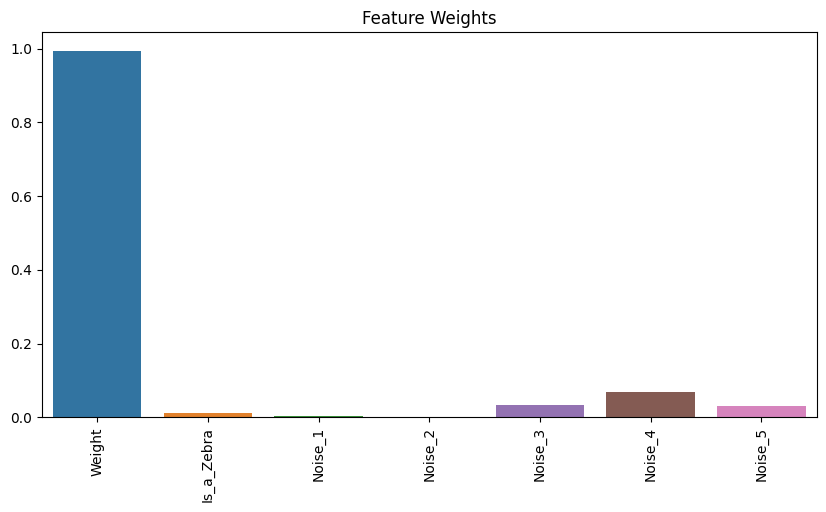

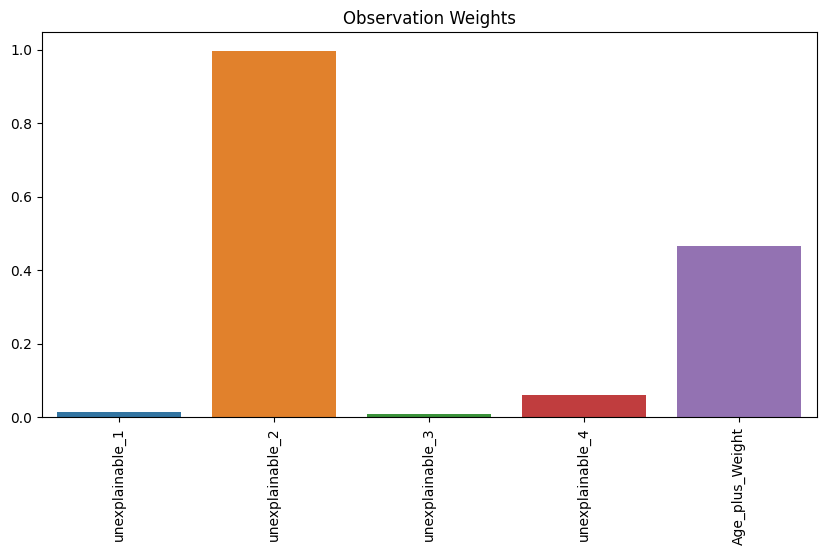

In [39]:
next2_model.plot()

In [40]:
feature_dict, observation_dict = next2_model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

remaining_features, remaining_observations

(['Is_a_Zebra', 'Noise_1', 'Noise_2', 'Noise_3', 'Noise_4', 'Noise_5'],
 ['Individual',
  'unexplainable_1',
  'unexplainable_3',
  'unexplainable_4',
  'Age_plus_Weight'])

In [41]:
next3_model = FeatureSelectionModel(
    df_explainable.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

my_model = next3_model

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': my_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = my_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {my_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.025800811961319656
1/10 --- Mean Loss : -0.19489734858538463
2/10 --- Mean Loss : -0.3039297338324828
3/10 --- Mean Loss : -0.31474773742549716
4/10 --- Mean Loss : -0.32010635955589734
5/10 --- Mean Loss : -0.32072339910619063
6/10 --- Mean Loss : -0.32084315020486687
7/10 --- Mean Loss : -0.3208739004679591
8/10 --- Mean Loss : -0.3206689445387365
9/10 --- Mean Loss : -0.32218971938639224
10/10 --- Mean Loss : -0.32267942453654425


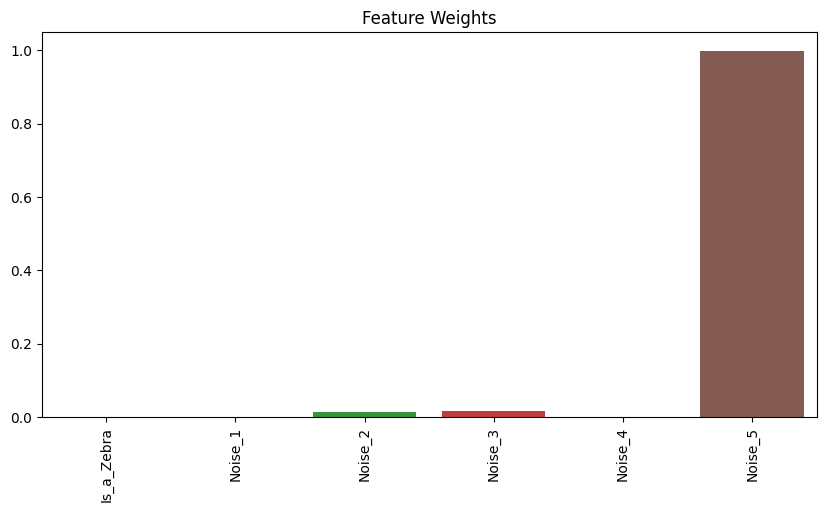

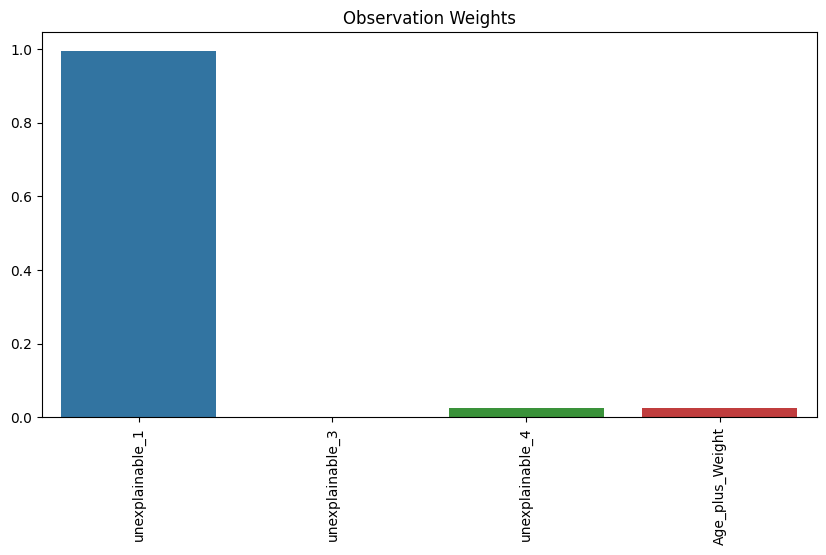

In [42]:
next3_model.plot()

In [43]:
...

Ellipsis